# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install optuna
!pip install phik

     |████████████████████████████████| 390 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 679 kB 1.3 MB/s eta 0:00:01


In [91]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import seaborn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

import time

import optuna

import phik


In [92]:
try:
    df = pd.read_csv('/Study/Yandex_Practicum/Определение стоимости автомобилей/autos.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/autos.csv')
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [94]:
strings_before = df.shape[0]
strings_before

354369

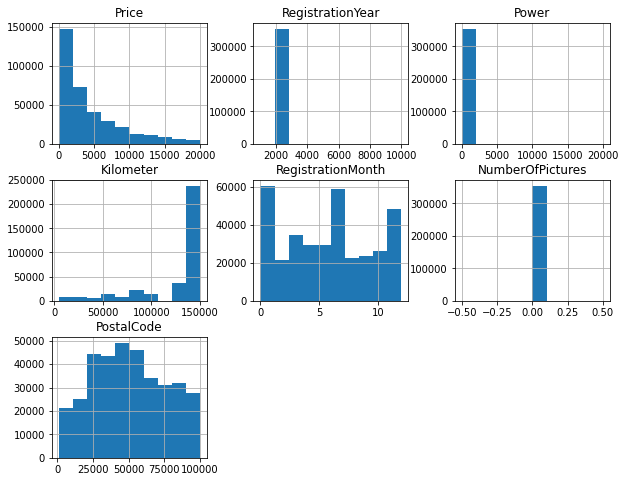

In [95]:
df.hist(figsize=(10, 8));

In [96]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [97]:
df.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [98]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Вывод: в данных есть пропуски и аномальные значения, со всем этим попытаемся разобраться далее.

### Предобработка данных

**Посмотрим значения в столбце с ценой.**

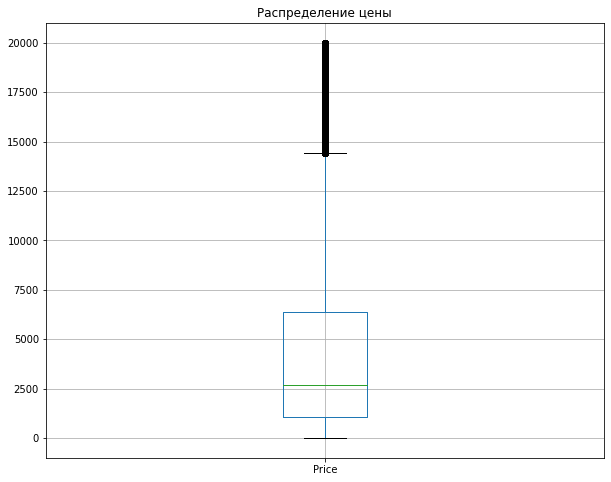

In [99]:
df['Price'].plot(kind='box', grid=True, figsize=(10, 8), title='Распределение цены');

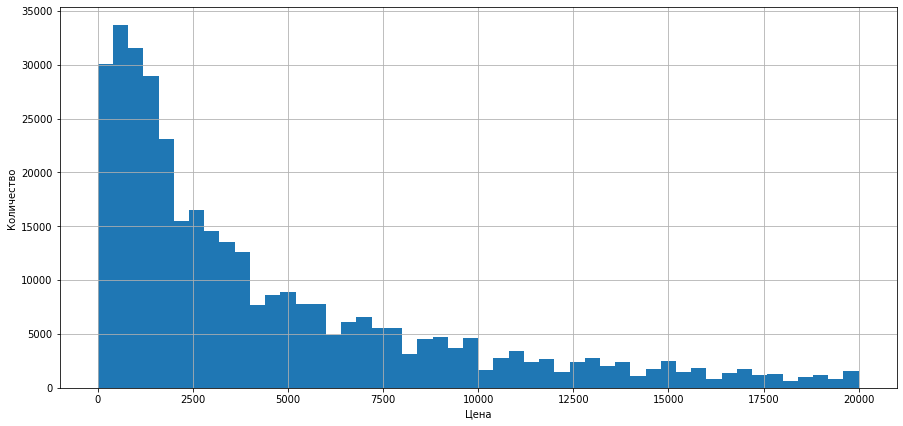

In [100]:
df['Price'].hist(bins=50, figsize=(15,7))
plt.xlabel('Цена')
plt.ylabel('Количество');


In [101]:
df = df.query('Price > 100')

In [102]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          32251
RegistrationYear         0
Gearbox              16085
Power                    0
Model                16889
Kilometer                0
RegistrationMonth        0
FuelType             28004
Brand                    0
Repaired             63867
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Поменяем значения в столбце с типом кузова**

In [103]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [104]:
df['VehicleType'] = df['VehicleType'].fillna('other')

Сделал я так потому, что одинаковые модели могут иметь разные типы кузова.

**Посмотрим значения в столбце с датой регистрации автомобиля**

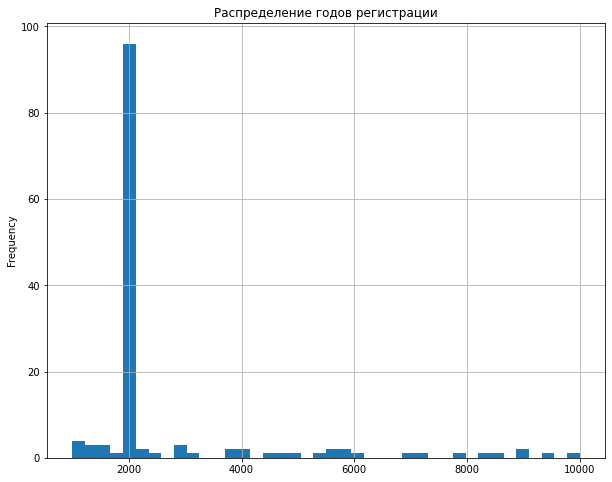

In [105]:
pd.Series(list(df['RegistrationYear'].unique())).plot(kind='hist', 
                                                      grid=True, bins=40, figsize=(10, 8), 
                                                      title='Распределение годов регистрации');

In [106]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1000,
       1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300,
       9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948, 1952,
       8500, 1932, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       5600, 1600, 1111, 1039, 1300, 2800, 1931, 4500, 1602, 7800, 1947,
       1927, 7100, 8200, 1946])

In [107]:
df = df.query('2017 > RegistrationYear > 1980')

**Далее посмотрим на пропуски в столбце с типом коробки передач**

In [108]:
df.query('Gearbox.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
16,2016-04-01 12:46:46,300,other,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,other,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,other,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16 00:00:00,0,51427,2016-03-21 09:47:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16 00:00:00,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,other,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30 00:00:00,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,other,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04


In [109]:
df = df.dropna(subset=['Gearbox'])

**Посмотрим на столбец с количеством лошадиных сил**

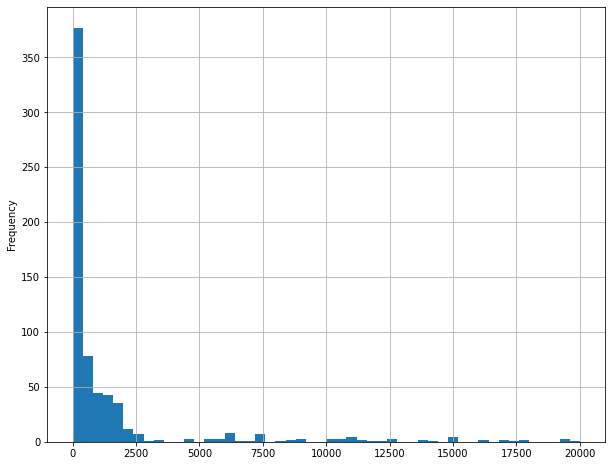

In [110]:
pd.Series(df['Power'].unique()).plot(kind='hist', bins=50, grid=True, figsize=(10, 8));

In [111]:
for col in df['Model'].unique():
       df.loc[(df['Model'] == col) & (df['Power']==0), 'Power'] = df.loc[(df['Model']==col) &  (df['Power']!=0), 'Power'].median()
        

In [112]:
df = df.query('15 < Power < 2500')

**Посмотрим на столбец с моделями автомобилей**

In [113]:
df.query('Model.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
81,2016-04-03 12:56:45,350,small,1997,manual,54.0,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136.0,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
193,2016-03-27 12:47:45,1200,coupe,1990,manual,45.0,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27 00:00:00,0,83317,2016-04-07 08:17:08
273,2016-03-29 23:38:02,1500,coupe,1994,manual,116.0,NaN,150000,8,NaN,audi,no,2016-03-29 00:00:00,0,32791,2016-04-06 20:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354077,2016-03-21 08:36:18,200,small,1998,manual,37.0,NaN,150000,4,petrol,volkswagen,yes,2016-03-21 00:00:00,0,26382,2016-04-06 02:45:28
354234,2016-03-19 01:47:31,5000,sedan,2002,auto,170.0,NaN,150000,0,petrol,audi,no,2016-03-18 00:00:00,0,85221,2016-04-06 03:45:36
354245,2016-03-07 16:37:42,560,small,2001,auto,170.0,NaN,90000,0,petrol,fiat,yes,2016-03-07 00:00:00,0,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200.0,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15 00:00:00,0,91186,2016-03-17 08:16:25


In [114]:
df.dropna(subset=['Model'], inplace=True)

**Далее посмотрим на столбец с пробегом**

<AxesSubplot:>

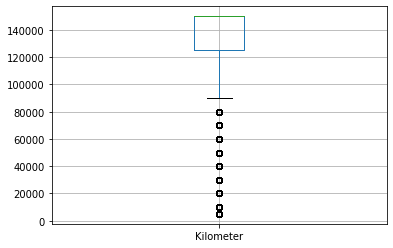

In [115]:
df.boxplot('Kilometer')

**Посмотрим на столбец с месяцом регистрации**

In [116]:
df['RegistrationMonth'].value_counts()

3     30480
6     27386
4     25618
5     25487
7     23672
10    23103
12    21310
11    21175
9     21166
1     20062
8     19824
0     18852
2     18714
Name: RegistrationMonth, dtype: int64

Видно, что есть нулевой месяц, заменим его на среднее значение.

In [117]:
# сколько значений для замены надо
size = (df['RegistrationMonth'] == 0).sum()
size

18852

In [119]:
# вероятности значений от 1 до 12
probs = df.query('RegistrationMonth!=0')['RegistrationMonth'].value_counts(normalize=True).sort_index()
probs

1     0.072166
2     0.067317
3     0.109641
4     0.092152
5     0.091681
6     0.098512
7     0.085152
8     0.071310
9     0.076138
10    0.083105
11    0.076170
12    0.076656
Name: RegistrationMonth, dtype: float64

In [46]:
res = np.random.choice(a = np.arange(1,13), size=size, p=probs)

<AxesSubplot:>

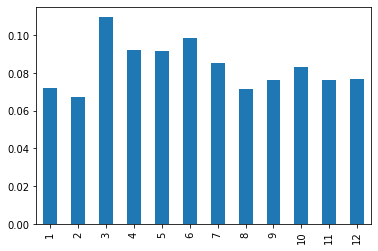

In [47]:
# распределение значений было
probs.plot.bar()

<AxesSubplot:>

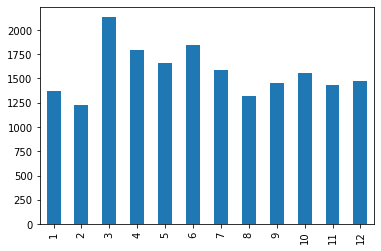

In [48]:
# распределение значений новое
pd.Series(res).value_counts().sort_index().plot.bar()

In [50]:
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = res

**Рассмотрим столбец с типом топлива**

In [36]:
df.query('FuelType.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
9,2016-03-17 10:53:50,999,small,1998,manual,101.0,golf,150000,6,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
13,2016-03-21 21:37:40,2500,wagon,2004,manual,131.0,passat,150000,2,NaN,volkswagen,no,2016-03-21 00:00:00,0,90762,2016-03-23 02:50:54
36,2016-03-11 11:50:37,1600,other,1991,manual,75.0,kadett,70000,6,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
41,2016-03-30 20:38:20,7500,sedan,2002,auto,306.0,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,33649,2016-04-03 11:44:49
52,2016-04-04 10:57:36,1400,other,2016,manual,55.0,other,5000,1,NaN,hyundai,NaN,2016-04-04 00:00:00,0,34454,2016-04-06 12:45:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354326,2016-03-31 19:36:18,1300,small,1999,manual,75.0,2_reihe,125000,6,NaN,peugeot,NaN,2016-03-31 00:00:00,0,35102,2016-04-06 13:44:44
354327,2016-03-14 11:51:01,2999,wagon,2004,manual,234.0,vectra,100000,1,NaN,opel,NaN,2016-03-14 00:00:00,0,83364,2016-03-16 23:46:11
354339,2016-03-20 12:46:00,3850,convertible,2006,manual,108.0,2_reihe,125000,2,NaN,peugeot,no,2016-03-20 00:00:00,0,53947,2016-03-26 21:18:23
354346,2016-03-07 17:06:35,2600,other,2005,auto,143.0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38


In [37]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Пропуски можно отнести к категории other.

In [38]:
df['FuelType'] = df['FuelType'].fillna('other')

In [39]:
df['Brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

В марках ничего изменять и заполнять не надо.

**Посмотрим на столбец с информацией о ремонте**

In [40]:
df['Repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [41]:
df['Repaired'].isna().sum()

44665

In [42]:
df['Repaired'] = df['Repaired'].fillna('unknown')

**Посмотрим на столбец с количеством фотографий**

In [43]:
df['NumberOfPictures'].unique()

array([0])

Везде стоят нули, и тем более количество фотографий не влияет на рыночную стоимость автомобиля. А влияет на скорость продажи. Поэтому удалим этот столбец.

In [44]:
df = df.drop(['NumberOfPictures'], axis=1)

Так как в столбце 36444 пропусков, а это примерно 10% выборки, то заменим пропуски на "unknown".

Далее хочу удалить столбцы, которые никак не влияют на формирование цены автомобиля.

In [45]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

In [46]:
df = df.reset_index(drop=True)

In [47]:
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,other,1993,manual,101.0,golf,150000,6,petrol,volkswagen,unknown
1,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown
2,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
3,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no
4,650,sedan,1995,manual,102.0,3er,150000,10,petrol,bmw,yes


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296849 entries, 0 to 296848
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              296849 non-null  int64  
 1   VehicleType        296849 non-null  object 
 2   RegistrationYear   296849 non-null  int64  
 3   Gearbox            296849 non-null  object 
 4   Power              296849 non-null  float64
 5   Model              296849 non-null  object 
 6   Kilometer          296849 non-null  int64  
 7   RegistrationMonth  296849 non-null  int64  
 8   FuelType           296849 non-null  object 
 9   Brand              296849 non-null  object 
 10  Repaired           296849 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 24.9+ MB


In [49]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [50]:
print('Осталось данных от исходной выборки- {:.0%}'.format(df.shape[0] / strings_before))

Осталось данных от исходной выборки- 84%


In [51]:
df.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Price,1.000000,0.278748,0.690819,0.328142,0.216712,0.581412,0.321094,0.109357,0.273297,0.343310,0.339171
VehicleType,0.278748,1.000000,0.377340,0.286439,0.111346,0.917187,0.177039,0.113183,0.370455,0.599348,0.217340
RegistrationYear,0.690819,0.377340,1.000000,0.129570,0.060109,0.625229,0.442115,0.115327,0.297289,0.320993,0.239333
Gearbox,0.328142,0.286439,0.129570,1.000000,0.262265,0.649851,0.022446,0.043111,0.150375,0.496359,0.021968
Power,0.216712,0.111346,0.060109,0.262265,1.000000,0.419958,0.018774,0.009701,0.071695,0.199585,0.032150
Model,0.581412,0.917187,0.625229,0.649851,0.419958,1.000000,0.448926,0.129025,0.537371,0.998495,0.225596
Kilometer,0.321094,0.177039,0.442115,0.022446,0.018774,0.448926,1.000000,0.040057,0.149223,0.269083,0.226008
RegistrationMonth,0.109357,0.113183,0.115327,0.043111,0.009701,0.129025,0.040057,1.000000,0.116777,0.066524,0.190495
FuelType,0.273297,0.370455,0.297289,0.150375,0.071695,0.537371,0.149223,0.116777,1.000000,0.284147,0.169254
Brand,0.343310,0.599348,0.320993,0.496359,0.199585,0.998495,0.269083,0.066524,0.284147,1.000000,0.140276


### Подготовка выборок для обучения моделей

In [52]:
RANDOM_STATE = 12345

#Выделим категориальные и числовые переменные
category = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'RegistrationYear']
numeric = ['Power', 'Kilometer']

#Разделим данные на фичи и таргет
features = df.drop('Price', axis=1)
target = df['Price']

In [53]:
features_ohe = pd.get_dummies(features, columns=category)
features_ohe.head(5)

,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,RegistrationYear_2007,RegistrationYear_2008,RegistrationYear_2009,RegistrationYear_2010,RegistrationYear_2011,RegistrationYear_2012,RegistrationYear_2013,RegistrationYear_2014,RegistrationYear_2015,RegistrationYear_2016
0,101.0,150000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,163.0,125000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,75.0,150000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,69.0,90000,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,102.0,150000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#Теперь проведем скалирование числовых признаков

scaler = StandardScaler()
scaler.fit(features_ohe[numeric])
features_ohe[numeric] = scaler.transform(features_ohe[numeric])
features_ohe.head(5)

,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,RegistrationYear_2007,RegistrationYear_2008,RegistrationYear_2009,RegistrationYear_2010,RegistrationYear_2011,RegistrationYear_2012,RegistrationYear_2013,RegistrationYear_2014,RegistrationYear_2015,RegistrationYear_2016
0,-0.326897,0.581806,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.672631,-0.106262,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.746054,0.581806,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.842782,-1.069558,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,-0.310775,0.581806,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features_ohe, target, test_size=0.4, random_state=RANDOM_STATE)
print('Размер обучающей выбрки:', features_train.shape)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=RANDOM_STATE)

print('Размер валидационная выбрки:', features_valid.shape)
print('Размер тестовой выбрки:', features_test.shape)

Размер обучающей выбрки: (178109, 357)
Размер валидационная выбрки: (59370, 357)
Размер тестовой выбрки: (59370, 357)


## Обучение моделей

Напишем функцию для расчета RMSE.

In [156]:
def rmse(test, predictions):
    return round(mean_squared_error(test, predictions)**0.5, 2)

In [157]:
def illustration(test,predictions):
    plt.figure(figsize=(8, 5))
    pd.Series(test).hist(bins=20, alpha=0.5)
    pd.Series(predictions).hist(bins=20, alpha=0.5)
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()

Начнем с простых моделей.

### Случайный лес

In [158]:
%%time
model_rf = RandomForestRegressor(random_state=RANDOM_STATE, criterion='friedman_mse',warm_start=False, n_estimators=100)
model_rf.fit(features_train, target_train)

CPU times: total: 7min 40s
Wall time: 7min 43s


RandomForestRegressor(criterion='friedman_mse', random_state=12345)

In [159]:
%%time
predict_rf=model_rf.predict(features_valid)

CPU times: total: 2.45 s
Wall time: 2.47 s


In [160]:
print('RMSE случайного леса:', rmse(target_valid, predict_rf))

RMSE случайного леса: 1574.95


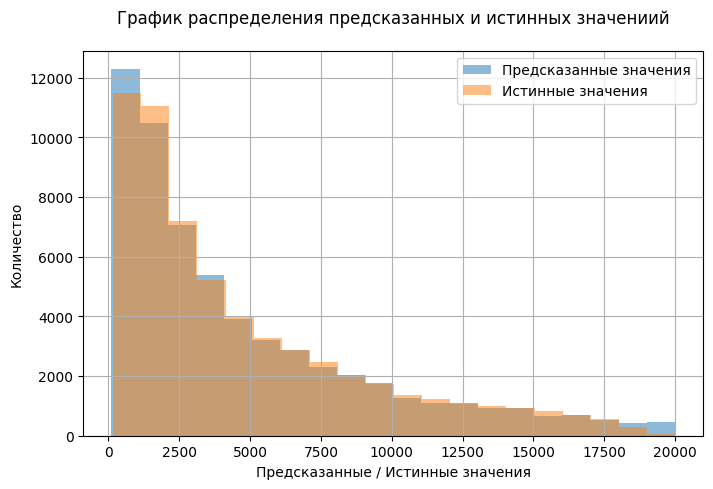

In [161]:
illustration(target_valid, predict_rf)

### Линейная регрессия

In [162]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: total: 28.2 s
Wall time: 5.78 s


LinearRegression()

In [163]:
%%time
predict_lr = model_lr.predict(features_valid)

CPU times: total: 93.8 ms
Wall time: 96.7 ms


In [164]:
print('RMSE линейной регрессии:', rmse(target_valid, predict_lr))

RMSE линейной регрессии: 2101.17


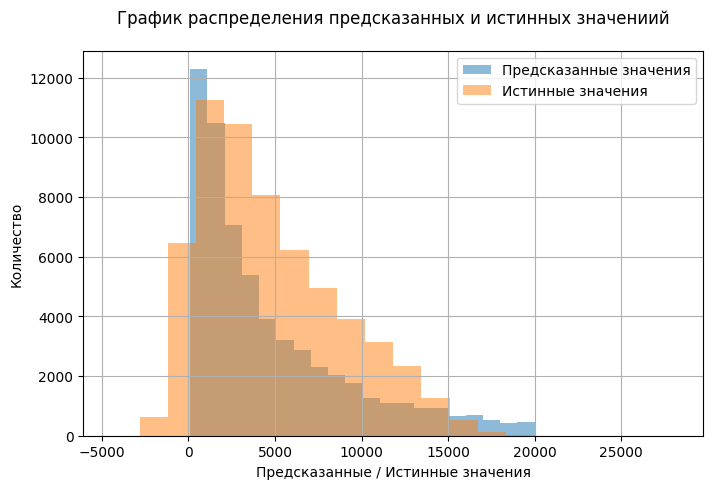

In [165]:
illustration(target_valid, predict_lr)

### LGBM регрессор

In [166]:
def objective(trial):
    params = {'verbosity':-1,
              'max_depth':trial.suggest_int('max_depth', 5, 100, step=5),
              'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
              'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.1, step=0.01),
              'random_state': RANDOM_STATE
             }
    reg = LGBMRegressor(**params)
    reg.fit(features_train, target_train)
    pr = reg.predict(features_valid)
    rmse1 = rmse(target_valid, pr)
    return rmse1

In [167]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-06-05 03:28:03,010] A new study created in memory with name: no-name-28b758c3-1fa9-459e-8804-589c251b1179
[I 2023-06-05 03:28:04,375] Trial 0 finished with value: 1606.41 and parameters: {'max_depth': 20, 'num_leaves': 85, 'learning_rate': 0.07100000000000001}. Best is trial 0 with value: 1606.41.
[I 2023-06-05 03:28:05,672] Trial 1 finished with value: 1605.85 and parameters: {'max_depth': 75, 'num_leaves': 65, 'learning_rate': 0.081}. Best is trial 1 with value: 1605.85.
[I 2023-06-05 03:28:06,848] Trial 2 finished with value: 1903.52 and parameters: {'max_depth': 80, 'num_leaves': 45, 'learning_rate': 0.031}. Best is trial 1 with value: 1605.85.
[I 2023-06-05 03:28:08,058] Trial 3 finished with value: 1698.58 and parameters: {'max_depth': 85, 'num_leaves': 35, 'learning_rate': 0.07100000000000001}. Best is trial 1 with value: 1605.85.
[I 2023-06-05 03:28:09,201] Trial 4 finished with value: 1831.09 and parameters: {'max_depth': 15, 'num_leaves': 25, 'learning_rate': 0.051000

In [168]:
study.best_params

{'max_depth': 60, 'num_leaves': 105, 'learning_rate': 0.091}

In [169]:
%%time
lgbm_model = LGBMRegressor(**study.best_params)
lgbm_model.fit(features_train, target_train)


CPU times: total: 8.44 s
Wall time: 1.26 s


LGBMRegressor(learning_rate=0.091, max_depth=60, num_leaves=105)

In [170]:
%%time
predict_lgbm = lgbm_model.predict(features_valid)

CPU times: total: 1.23 s
Wall time: 198 ms


In [171]:
print('RMSE LGBM регрессора:', rmse(target_valid, predict_lgbm))

RMSE LGBM регрессора: 1552.38


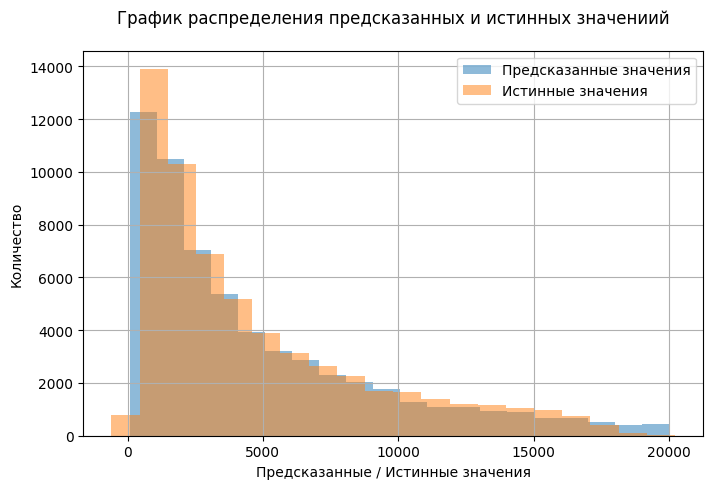

In [172]:
illustration(target_valid, predict_lgbm)

### CatBoost регрессор

In [173]:
%%time
model_cb = CatBoostRegressor(loss_function='RMSE', iterations=20, depth = 16, random_state=RANDOM_STATE)
model_cb.fit(features_train, target_train, verbose=20)

Learning rate set to 0.5
0:	learn: 3147.6062635	total: 758ms	remaining: 14.4s
19:	learn: 1563.7212092	total: 15.6s	remaining: 0us
CPU times: total: 49.9 s
Wall time: 16 s


In [174]:
%%time
predict_cr = model_cb.predict(features_valid)

CPU times: total: 203 ms
Wall time: 49.9 ms


In [175]:
print('RMSE CatBoost регрессора:', rmse(target_valid, predict_cr))

RMSE CatBoost регрессора: 1642.84


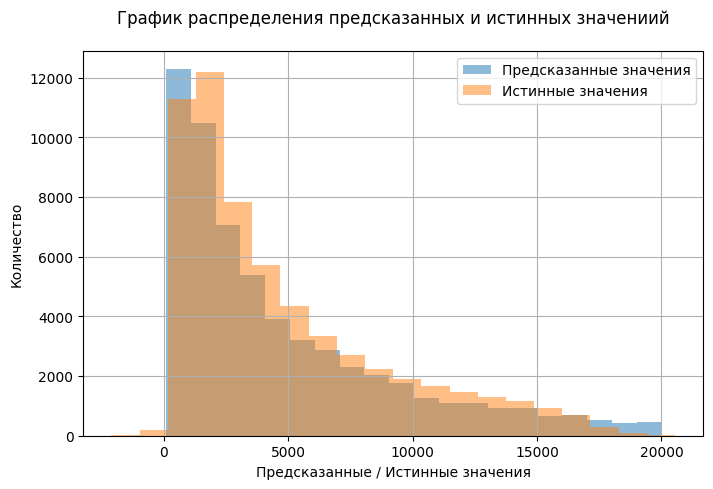

In [176]:
illustration(target_valid, predict_cr)

## Анализ моделей

In [56]:
pd.DataFrame({'Названия моделей': ['Случайный лес', 'Линейная регрессия', 'LGBM', 'CatBoost'], 'RMSE': [1574.95, 2101.17, 1552.38, 1642.84], 
              'Время обучения': ['16min 23s', '10.4 s', '2m 19s', '16.3 s'], 'Время предсказания': ['7.92 s', '183 ms', '187 ms', '58.8 ms']})

,Названия моделей,RMSE,Время обучения,Время предсказания
0,Случайный лес,1574.95,16min 23s,7.92 s
1,Линейная регрессия,2101.17,10.4 s,183 ms
2,LGBM,1552.38,2m 19s,187 ms
3,CatBoost,1642.84,16.3 s,58.8 ms


Исходя из проведенного анализа, можно сделать вывод, что LGBMRegressor имеет самое маленькое RMSE(более точные предсказания), модель CatBoost - наименьшее время предсказания, а линейная регрессия наименьшее время обучения. Поэтому предлагаю использовать модель LGBMRegressor.

In [178]:
%%time
predict_lgbm = lgbm_model.predict(features_test)

CPU times: total: 1.2 s
Wall time: 201 ms


In [179]:
print('RMSE LGBM регрессора на тестовой выборке:', rmse(target_test, predict_lgbm))

RMSE LGBM регрессора на тестовой выборке: 1542.4
